## Advanced Practice Problems: Charting with `mplfinance`

This notebook contains **advanced (but not too much)** exercises with **fully worked solutions**.

**Best practices used here:**
- Clear, reusable helper functions
- Input validation + defensive checks
- No mutation of original input `DataFrame` unless explicitly intended
- Sensible defaults + configurable parameters
- Plots designed to be readable (titles, labels, figure sizing)

### Assumptions
- You have an OHLCV CSV like `AAPL_data.csv` with columns: `date, open, high, low, close, volume`.
- Dates are trading days (but we may optionally show non-trading gaps).


### Setup

In [1]:
import warnings

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplfinance as mpf

mpl.style.use('seaborn-v0_8-darkgrid')
warnings.filterwarnings('ignore')

### Load and validate data

`mplfinance` expects a DateTimeIndex and columns named (case-insensitive) like Open/High/Low/Close/Volume.
We'll standardize to lowercase: `open, high, low, close, volume`.

In [2]:
def load_ohlcv_csv(
    path: str,
    date_col: str = 'date',
    cols=('open', 'high', 'low', 'close', 'volume'),
) -> pd.DataFrame:
    """Load OHLCV CSV into a clean DataFrame suitable for mplfinance."""
    usecols = [date_col, *cols]
    df = pd.read_csv(
        path,
        usecols=usecols,
        parse_dates=[date_col],
        index_col=date_col,
        skipinitialspace=True,
    )
    df.columns = [c.strip().lower() for c in df.columns]
    df = df.sort_index()

    required = set(cols)
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"Missing required columns: {sorted(missing)}")

    # Basic integrity checks
    if not isinstance(df.index, pd.DatetimeIndex):
        raise TypeError("Index must be a DatetimeIndex")
    if df.index.has_duplicates:
        # Keep last occurrence as a reasonable default
        df = df[~df.index.duplicated(keep='last')]

    # Coerce numeric
    for c in cols:
        df[c] = pd.to_numeric(df[c], errors='coerce')

    # Drop rows with incomplete OHLC
    df = df.dropna(subset=['open', 'high', 'low', 'close'])

    return df


data = load_ohlcv_csv('AAPL_data.csv')
data.head()

,open,high,low,close,volume
date,,,,,
2013-02-08,67.7142,68.4014,66.8928,67.8542,158168416
2013-02-11,68.0714,69.2771,67.6071,68.5614,129029425
2013-02-12,68.5014,68.9114,66.8205,66.8428,151829363
2013-02-13,66.7442,67.6628,66.1742,66.7156,118721995
2013-02-14,66.3599,67.3771,66.2885,66.6556,88809154


### Utility helpers (used across problems)

We'll build small helpers for indicators and plotting overlays.

In [3]:
def add_bollinger_bands(
    df: pd.DataFrame,
    period: int = 20,
    num_std: float = 2.0,
    price_col: str = 'close',
) -> pd.DataFrame:
    """Return a copy with Bollinger Band columns: bb_mid, bb_upper, bb_lower."""
    if period <= 1:
        raise ValueError("period must be > 1")
    if num_std <= 0:
        raise ValueError("num_std must be > 0")
    if price_col not in df.columns:
        raise ValueError(f"Missing price column: {price_col}")

    out = df.copy()
    mid = out[price_col].rolling(period).mean()
    sd = out[price_col].rolling(period).std(ddof=0)
    out['bb_mid'] = mid
    out['bb_upper'] = mid + num_std * sd
    out['bb_lower'] = mid - num_std * sd
    return out


def rsi(series: pd.Series, period: int = 14) -> pd.Series:
    """Compute RSI using Wilder's smoothing (EMA-like)."""
    if period <= 1:
        raise ValueError("period must be > 1")
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.ewm(alpha=1/period, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1/period, adjust=False).mean()
    rs = avg_gain / avg_loss.replace(0, np.nan)
    return 100 - (100 / (1 + rs))


def ensure_window(df: pd.DataFrame, n: int) -> pd.DataFrame:
    """Return last n rows (or all rows if shorter)."""
    if n <= 0:
        raise ValueError("n must be > 0")
    return df.iloc[-n:] if len(df) > n else df


def make_style(base: str = 'seaborn-darkgrid'):
    return mpf.make_mpf_style(
        base_mpl_style=base,
        mavcolors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'],
        gridstyle='-',
        facecolor='white',
    )


my_style = make_style()

# Problem 1 — Candlestick + Volume + Two Moving Averages (clean API)

**Task:** Create a function `plot_basic_setup(df, n=200, mav=(20, 50))` that:
- Uses the last `n` rows
- Plots **candlesticks**
- Adds **volume**
- Adds **two moving averages**
- Adds readable labels + title

**Goal:** get used to a clean plotting function you can reuse.


## Solution 1

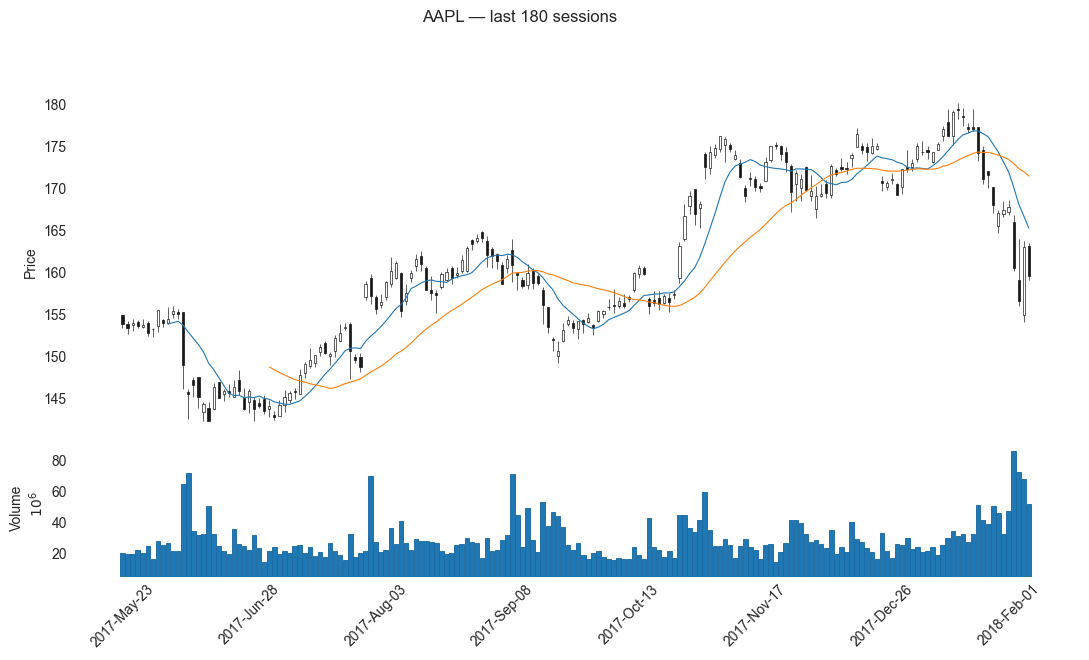

In [4]:
def plot_basic_setup(
    df: pd.DataFrame,
    n: int = 200,
    mav=(20, 50),
    title: str = 'OHLCV (Candles) with MAs',
    show_nontrading: bool = False,
    style=None,
):
    if style is None:
        style = my_style
    window = ensure_window(df, n)

    mpf.plot(
        window,
        type='candle',
        volume=True,
        mav=mav,
        show_nontrading=show_nontrading,
        title=title,
        ylabel='Price',
        ylabel_lower='Volume',
        figsize=(14, 7),
        style=style,
    )


plot_basic_setup(data, n=180, mav=(10, 30), title='AAPL — last 180 sessions')

# Problem 2 — Add Bollinger Bands as overlays

**Task:** Overlay Bollinger Bands (20-period, 2 std) on top of a candlestick chart.

Requirements:
- Compute `bb_mid`, `bb_upper`, `bb_lower`
- Use `mpf.make_addplot()` to draw them on the main price panel
- Plot last `n=200` rows


## Solution 2

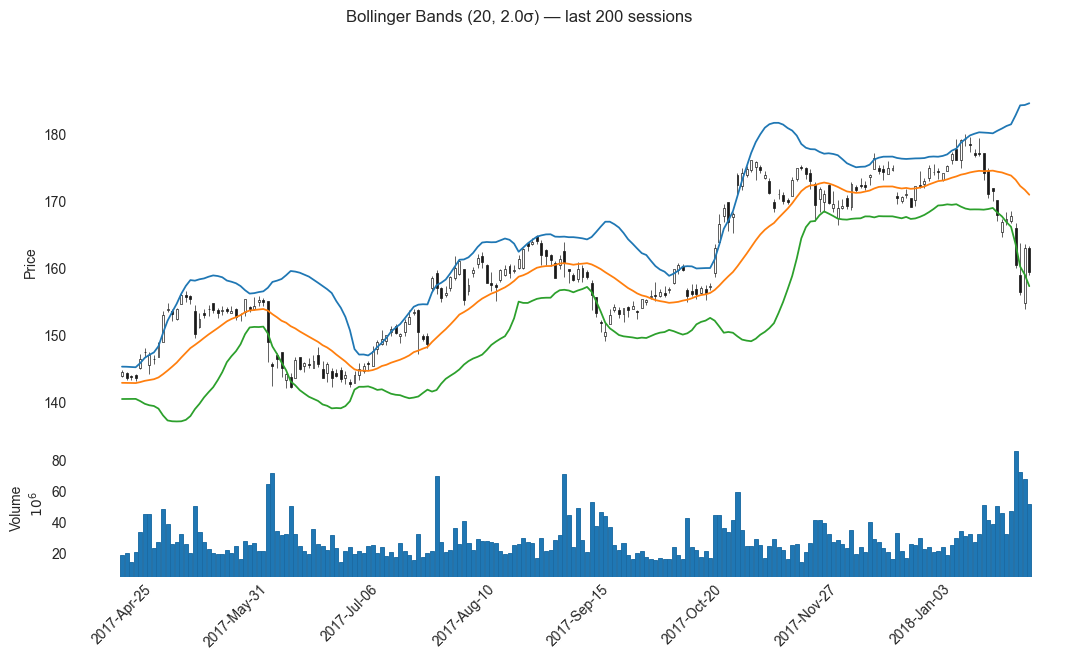

In [5]:
def plot_with_bollinger(df: pd.DataFrame, n: int = 200, period: int = 20, num_std: float = 2.0):
    d = add_bollinger_bands(df, period=period, num_std=num_std)
    w = ensure_window(d, n)

    ap = [
        mpf.make_addplot(w['bb_upper']),
        mpf.make_addplot(w['bb_mid']),
        mpf.make_addplot(w['bb_lower']),
    ]

    mpf.plot(
        w,
        type='candle',
        addplot=ap,
        volume=True,
        title=f'Bollinger Bands ({period}, {num_std}σ) — last {len(w)} sessions',
        ylabel='Price',
        ylabel_lower='Volume',
        figsize=(14, 7),
        style=my_style,
    )


plot_with_bollinger(data, n=200, period=20, num_std=2.0)

# Problem 3 — Add RSI in a separate panel

**Task:** Create a 2-panel chart:
- Panel 1: Candlesticks + MA(20)
- Panel 2: RSI(14)

Requirements:
- RSI is plotted in a **lower panel** using `make_addplot(..., panel=1)`
- Add horizontal reference lines at **30** and **70** (use `hlines` for that panel)

Hint: `mpf.plot()` supports `panel_ratios`.


## Solution 3

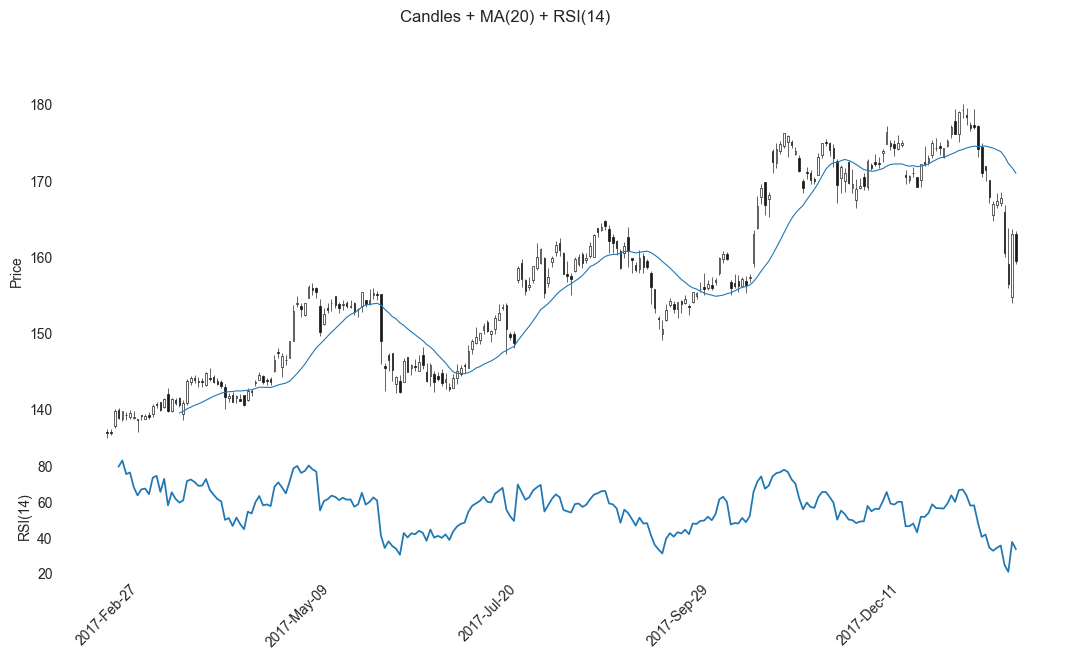

In [6]:
def plot_with_rsi(df: pd.DataFrame, n: int = 250, ma: int = 20, rsi_period: int = 14):
    w = ensure_window(df, n).copy()
    w['rsi'] = rsi(w['close'], period=rsi_period)

    ap = [
        mpf.make_addplot(w['rsi'], panel=1, ylabel=f'RSI({rsi_period})'),
    ]

    mpf.plot(
        w,
        type='candle',
        mav=(ma,),
        addplot=ap,
        volume=False,
        title=f'Candles + MA({ma}) + RSI({rsi_period})',
        ylabel='Price',
        figsize=(14, 7),
        panel_ratios=(3, 1),
        style=my_style,
    )


plot_with_rsi(data, n=240, ma=20, rsi_period=14)

# Problem 4 — Highlight "event" days (earnings-like markers)

**Task:** Simulate a few "event" dates and highlight them on the price chart.

Requirements:
- Pick 5 dates from within the plotted window
- Add vertical lines using `vlines` in `mpf.plot()`
- Add a title that lists how many events were marked

Note: In real work, event dates might come from a separate dataset.


## Solution 4

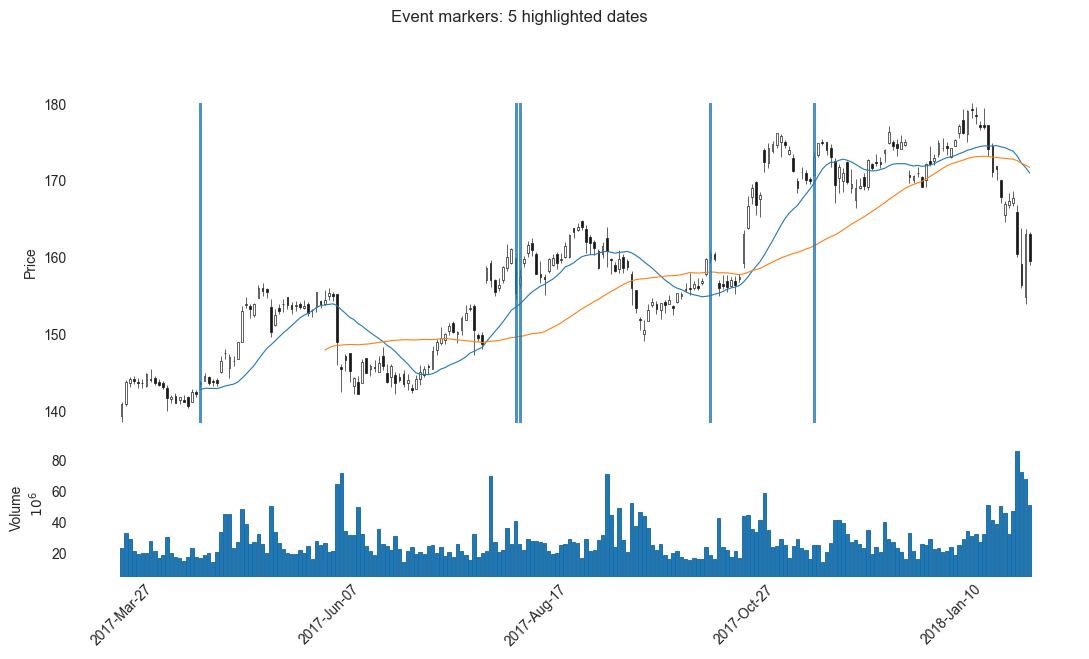

In [7]:
def plot_with_event_markers(df: pd.DataFrame, n: int = 220, k_events: int = 5, seed: int = 7):
    w = ensure_window(df, n)
    if len(w) < k_events:
        raise ValueError("Not enough rows to choose event dates")

    rng = np.random.default_rng(seed)
    event_idx = np.sort(rng.choice(np.arange(len(w)), size=k_events, replace=False))
    event_dates = w.index[event_idx].to_pydatetime().tolist()

    mpf.plot(
        w,
        type='candle',
        volume=True,
        mav=(20, 50),
        vlines=dict(vlines=event_dates, linewidths=1, alpha=0.8),
        title=f'Event markers: {k_events} highlighted dates',
        ylabel='Price',
        ylabel_lower='Volume',
        figsize=(14, 7),
        style=my_style,
    )


plot_with_event_markers(data, n=220, k_events=5, seed=42)

# Problem 5 — Create a custom style + consistent theme

**Task:** Build a custom `mplfinance` style to standardize the look:

- Base it on a Matplotlib style (e.g., `seaborn-darkgrid`)
- Ensure moving averages have distinct colors (`mavcolors`)
- Apply it to a candles + volume chart

**Stretch:** create two styles (light/dark) and choose one with a function argument.


## Solution 5

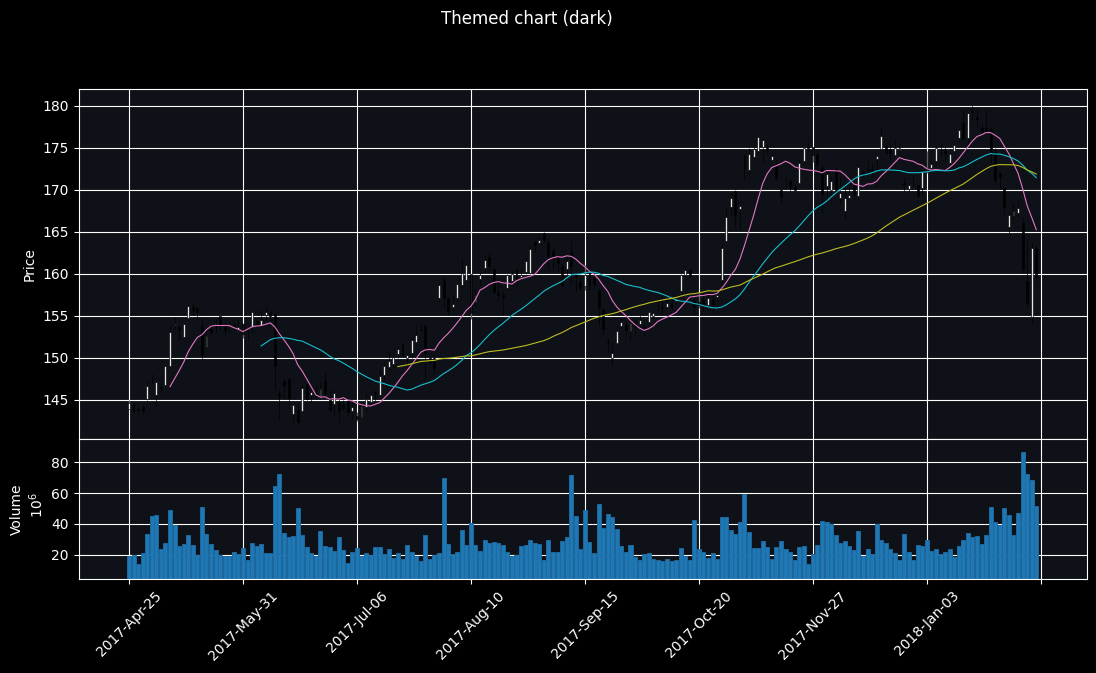

In [8]:
def make_two_styles():
    light = mpf.make_mpf_style(
        base_mpl_style='seaborn-darkgrid',
        facecolor='white',
        mavcolors=['#1f77b4', '#ff7f0e', '#2ca02c'],
        gridstyle='-',
    )
    dark = mpf.make_mpf_style(
        base_mpl_style='dark_background',
        facecolor='#0e1117',
        mavcolors=['#e377c2', '#17becf', '#bcbd22'],
        gridstyle='-',
    )
    return light, dark


LIGHT_STYLE, DARK_STYLE = make_two_styles()


def plot_with_theme(df: pd.DataFrame, n: int = 180, theme: str = 'light'):
    w = ensure_window(df, n)
    style = LIGHT_STYLE if theme.lower() == 'light' else DARK_STYLE

    mpf.plot(
        w,
        type='candle',
        volume=True,
        mav=(10, 30, 60),
        title=f'Themed chart ({theme})',
        ylabel='Price',
        ylabel_lower='Volume',
        figsize=(14, 7),
        style=style,
    )


plot_with_theme(data, n=200, theme='dark')

# Problem 6 — Detect and plot "high-volatility" days

**Task:** Compute a simple volatility proxy and visually emphasize high-volatility days.

Definition (simple, not perfect):
- `range_pct = (high - low) / close`
- Mark days where `range_pct` is above the **90th percentile** (within the plotted window)

Plot requirements:
- Candlestick chart for last `n=250`
- Add scatter markers on the close price for flagged days (use `make_addplot(..., scatter=True)`)

Tip: Provide the marker series with NaNs for non-flagged days.


## Solution 6

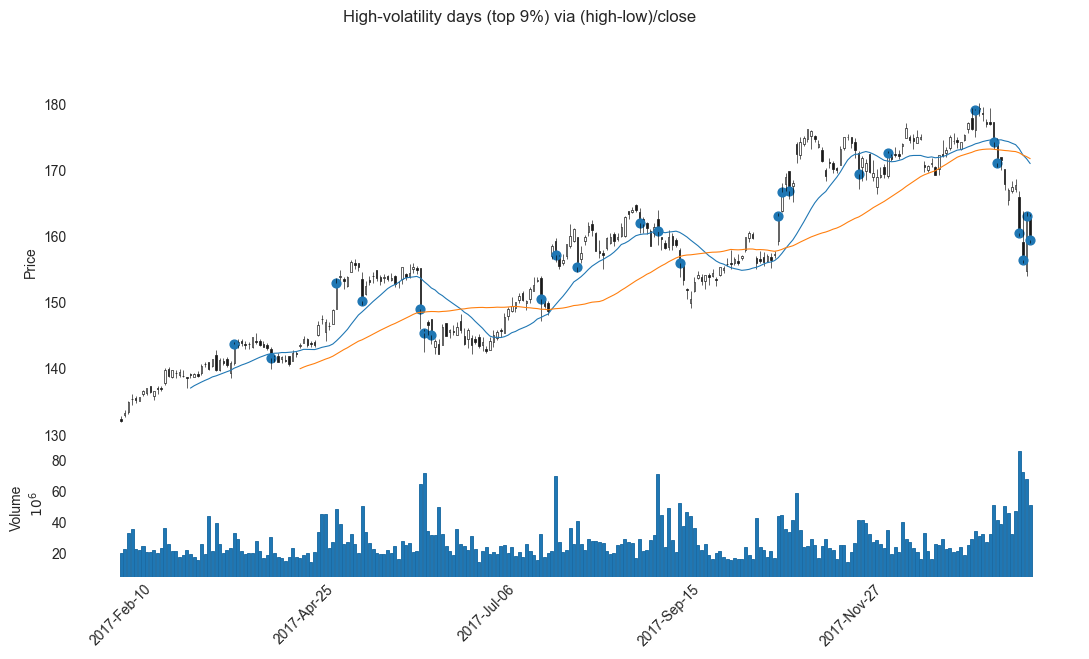

In [9]:
def plot_high_vol_days(df: pd.DataFrame, n: int = 250, q: float = 0.90):
    if not (0 < q < 1):
        raise ValueError("q must be between 0 and 1")

    w = ensure_window(df, n).copy()
    w['range_pct'] = (w['high'] - w['low']) / w['close']
    thresh = w['range_pct'].quantile(q)
    flagged = w['range_pct'] >= thresh

    marker_series = pd.Series(np.nan, index=w.index)
    marker_series.loc[flagged] = w.loc[flagged, 'close']

    ap = [
        mpf.make_addplot(marker_series, type='scatter', markersize=40),
    ]

    mpf.plot(
        w,
        type='candle',
        addplot=ap,
        volume=True,
        mav=(20, 50),
        title=f'High-volatility days (top {int((1-q)*100)}%) via (high-low)/close',
        ylabel='Price',
        ylabel_lower='Volume',
        figsize=(14, 7),
        style=my_style,
    )


plot_high_vol_days(data, n=250, q=0.90)

# Problem 7 — Multi-panel: Price + Volume + RSI (3 panels)

**Task:** Create a 3-panel chart:
- Panel 0: candlesticks + MA(20)
- Panel 1: volume (separate panel)
- Panel 2: RSI(14)

Requirements:
- Use `volume=False` and instead draw volume as an explicit addplot on panel 1
- Use `panel_ratios=(3,1,1)`

Why: This pattern is useful when you want full control of each panel.


## Solution 7

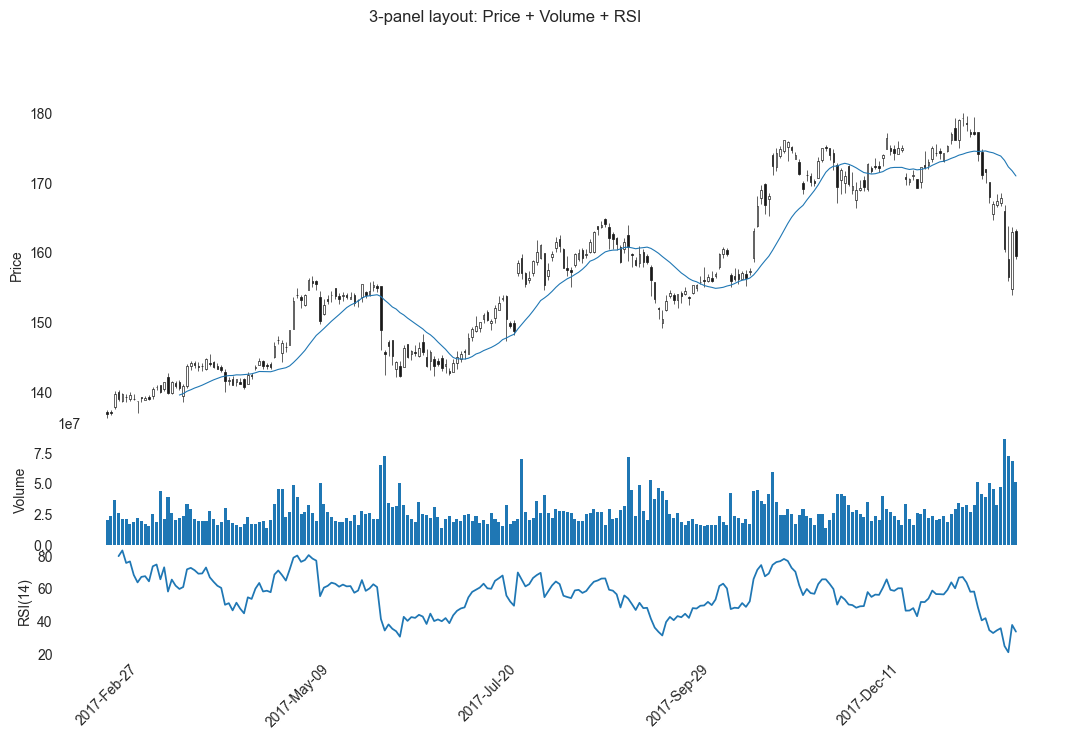

In [10]:
def plot_three_panels(df: pd.DataFrame, n: int = 260, ma: int = 20, rsi_period: int = 14):
    w = ensure_window(df, n).copy()
    w['rsi'] = rsi(w['close'], period=rsi_period)

    ap = [
        mpf.make_addplot(w['volume'], type='bar', panel=1, ylabel='Volume'),
        mpf.make_addplot(w['rsi'], panel=2, ylabel=f'RSI({rsi_period})'),
    ]

    mpf.plot(
        w,
        type='candle',
        mav=(ma,),
        addplot=ap,
        volume=False,
        panel_ratios=(3, 1, 1),
        title='3-panel layout: Price + Volume + RSI',
        ylabel='Price',
        figsize=(14, 8),
        style=my_style,
    )


plot_three_panels(data, n=240, ma=20, rsi_period=14)

# Problem 8 — Build a reusable "report" function (returns fig/axes)

**Task:** Create a function that:
- Plots candles + volume + Bollinger on panel 0
- Returns `fig, axes` by calling `mpf.plot(..., returnfig=True)`
- Adds a Matplotlib annotation (e.g., label the last close) after plotting

Why: returning the figure lets you do advanced Matplotlib customizations.


## Solution 8

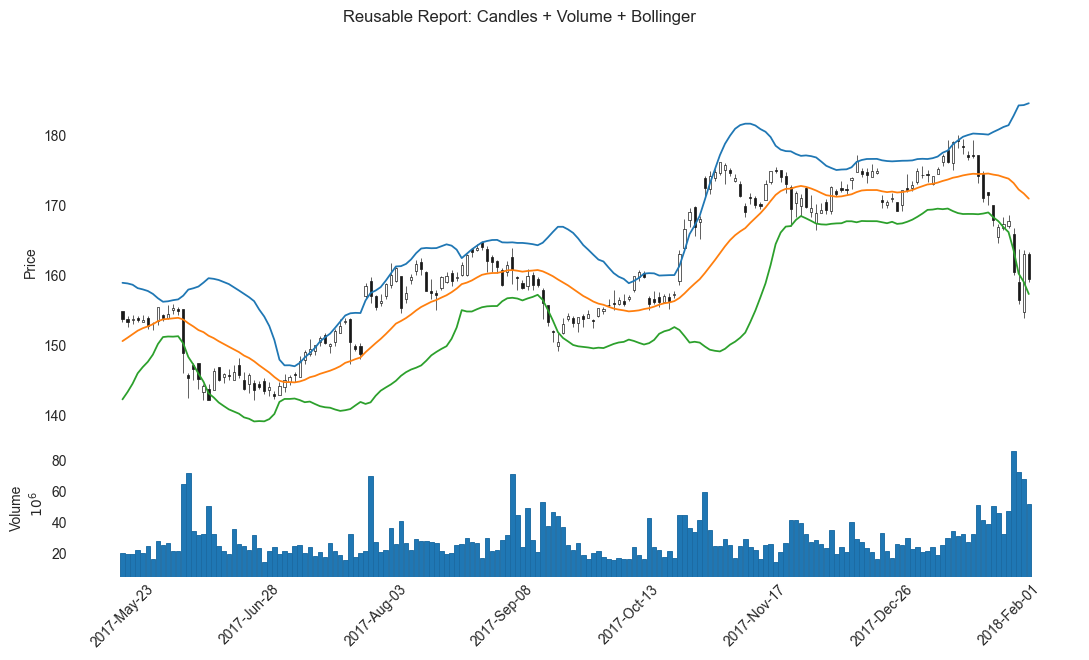

In [11]:
def plot_report(df: pd.DataFrame, n: int = 200, period: int = 20, num_std: float = 2.0):
    d = add_bollinger_bands(df, period=period, num_std=num_std)
    w = ensure_window(d, n)

    ap = [
        mpf.make_addplot(w['bb_upper']),
        mpf.make_addplot(w['bb_mid']),
        mpf.make_addplot(w['bb_lower']),
    ]

    fig, axes = mpf.plot(
        w,
        type='candle',
        addplot=ap,
        volume=True,
        figsize=(14, 7),
        style=my_style,
        title='Reusable Report: Candles + Volume + Bollinger',
        ylabel='Price',
        ylabel_lower='Volume',
        returnfig=True,
    )

    # axes[0] is typically the main price axis when volume=True
    ax_price = axes[0]
    last_dt = w.index[-1]
    last_close = float(w['close'].iloc[-1])
    ax_price.annotate(
        f'Last close: {last_close:.2f}',
        xy=(last_dt, last_close),
        xytext=(15, 15),
        textcoords='offset points',
        arrowprops=dict(arrowstyle='->', lw=1),
    )

    plt.show()
    return fig, axes


fig, axes = plot_report(data, n=180, period=20, num_std=2.0)

## Wrap-up

You now practiced:
- Clean reusable `mplfinance` plotting functions
- Overlays with `make_addplot()`
- Multi-panel layouts (including custom volume panels)
- Reference lines and event markers
- Returning `fig, axes` for advanced Matplotlib customization
